LOADING AND PREPROCESSING DATA
✓ Loaded 4920 samples with 41 diseases

⚠ Class Distribution (first 10):
Disease
Fungal infection       120
Allergy                120
GERD                   120
Chronic cholestasis    120
Drug Reaction          120
Peptic ulcer diseae    120
AIDS                   120
Diabetes               120
Gastroenteritis        120
Bronchial Asthma       120
Name: count, dtype: int64

✓ Found 131 unique symptoms

FEATURE ENGINEERING
✓ Feature matrix shape: (4920, 132)
✓ Average symptoms per patient: 7.45
✓ Min symptoms: 3, Max: 17

CREATING STRATIFIED TRAIN-TEST SPLIT
✓ Training set: 3936 samples
✓ Test set: 984 samples

TRAINING MODELS WITH CROSS-VALIDATION

[1/3] Training Random Forest...
Fitting 10 folds for each of 48 candidates, totalling 480 fits
✓ Best RF params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
✓ Best RF CV F1-score: 1.0000

[2/3] Training Gradient Boosting...
Fitting 10 folds for 

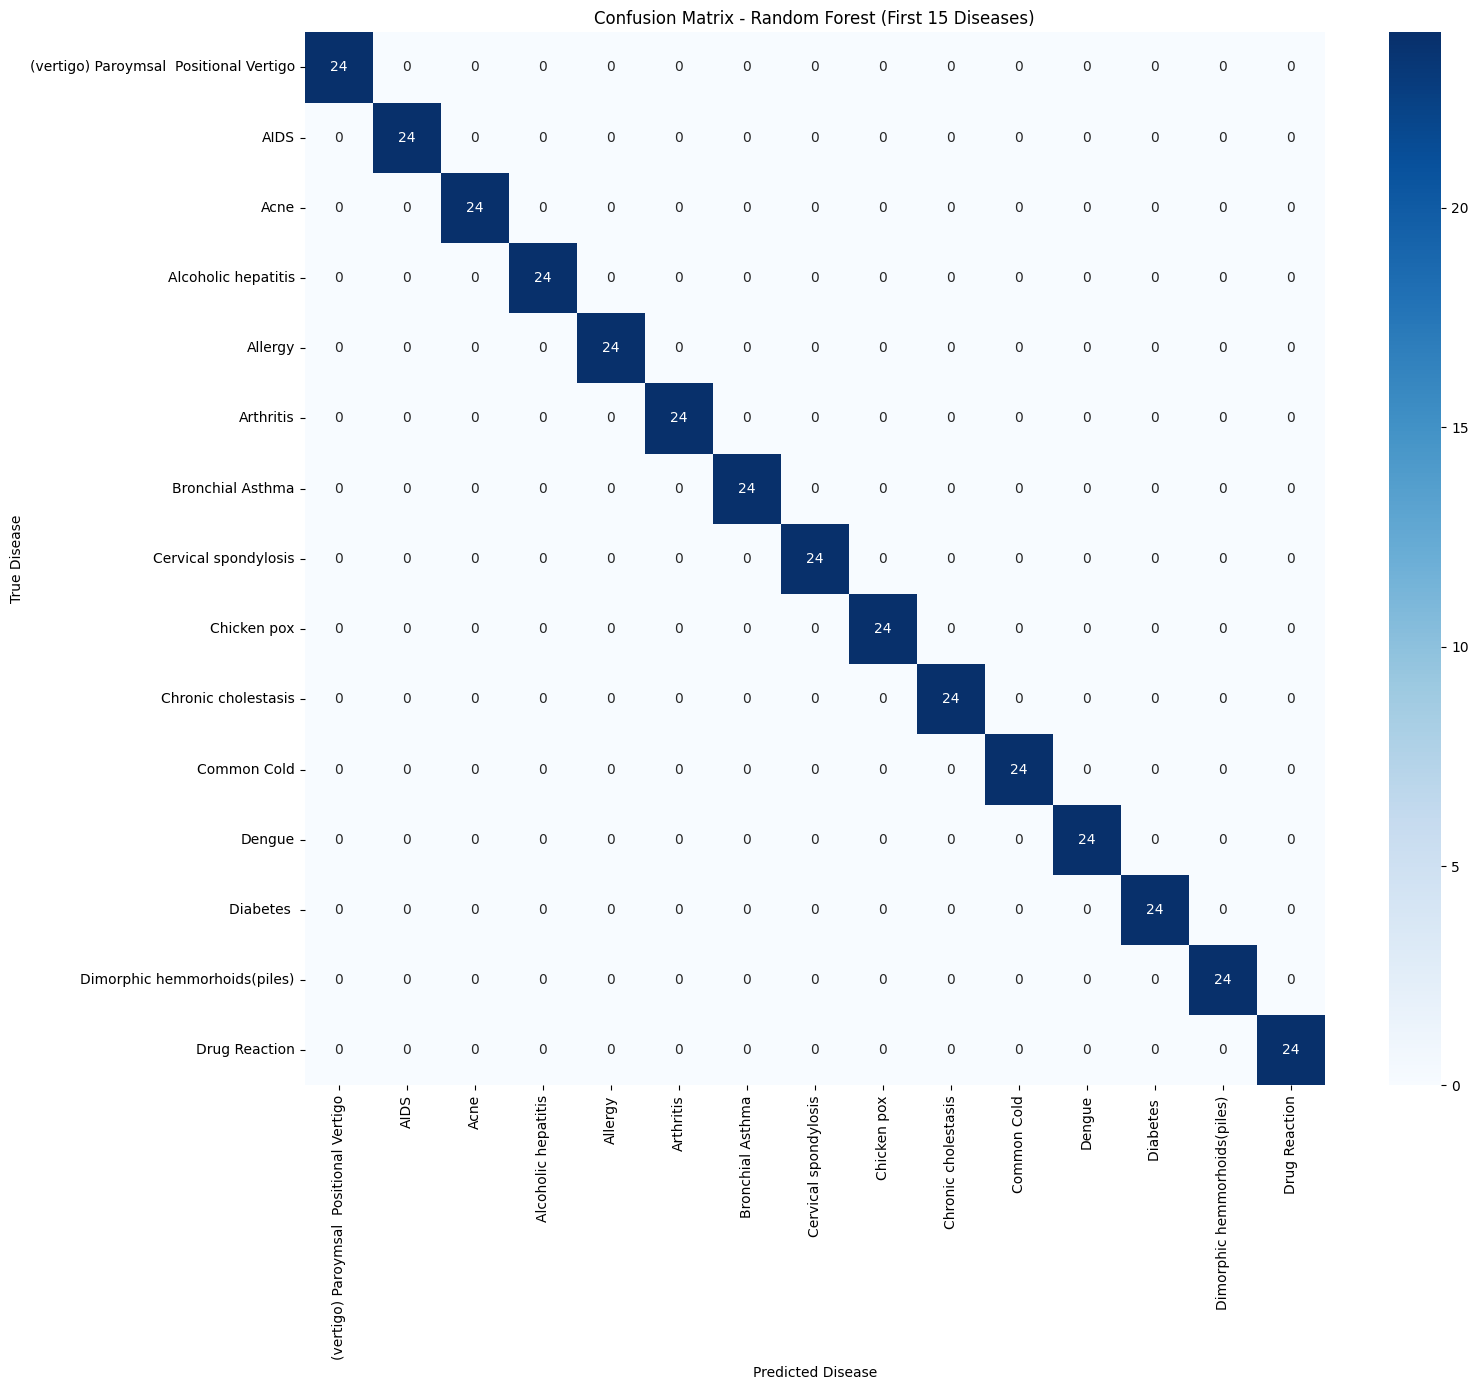

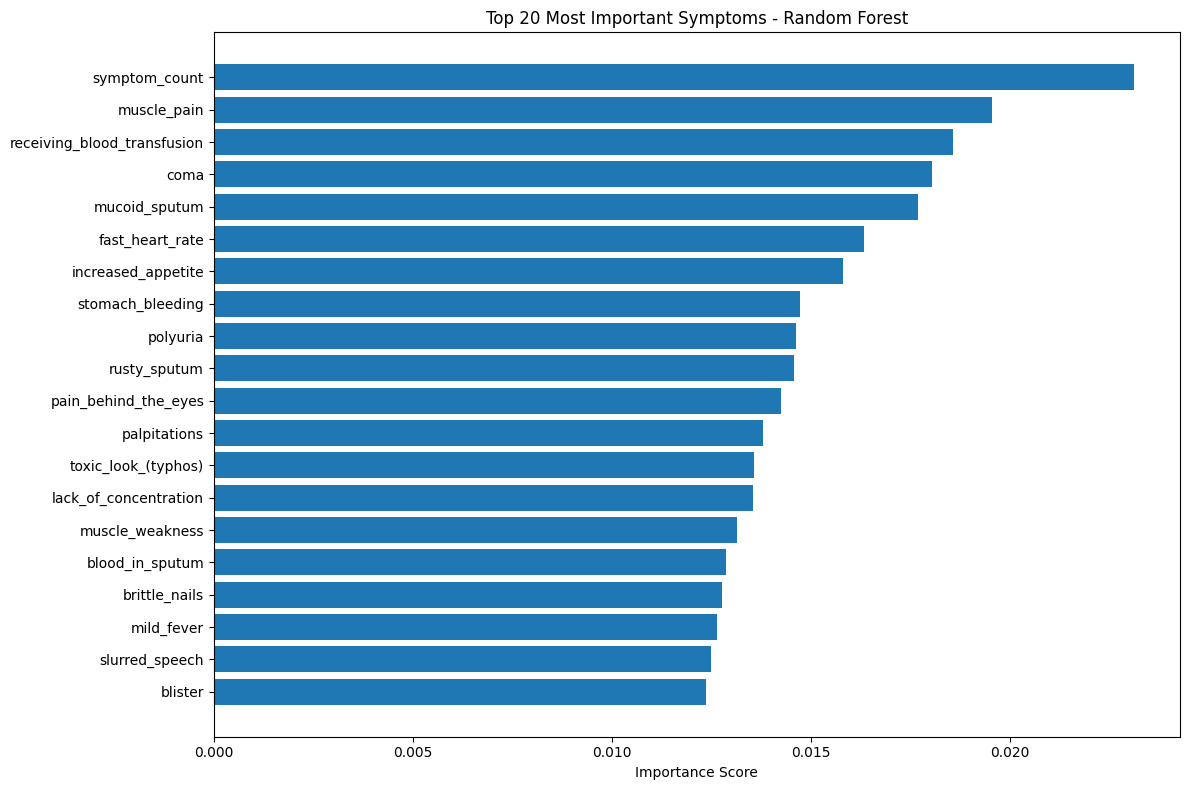

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# ==================== STEP 1: IMPROVED DATA LOADING ====================
print("=" * 60)
print("LOADING AND PREPROCESSING DATA")
print("=" * 60)

df = pd.read_csv("../data/dataset.csv")
print(f"✓ Loaded {len(df)} samples with {df['Disease'].nunique()} diseases")

# Check class distribution
disease_counts = df['Disease'].value_counts()
print(f"\n⚠ Class Distribution (first 10):")
print(disease_counts.head(10))

# Identify all unique symptoms
symptom_cols = [f'Symptom_{i}' for i in range(1, 18)]
all_symptoms = set()

for col in symptom_cols:
    symptoms = df[col].dropna().unique()
    all_symptoms.update([s.strip() for s in symptoms])

all_symptoms = sorted(list(all_symptoms))
print(f"\n✓ Found {len(all_symptoms)} unique symptoms")

# ==================== STEP 2: FEATURE ENGINEERING ====================
print("\n" + "=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Create binary symptom matrix
binary_data = []

for idx, row in df.iterrows():
    patient_symptoms = []
    
    # Extract this patient's symptoms
    for col in symptom_cols:
        if pd.notna(row[col]):
            patient_symptoms.append(row[col].strip())
    
    # Create binary vector
    binary_row = [1 if symptom in patient_symptoms else 0 for symptom in all_symptoms]
    binary_data.append(binary_row)

X = pd.DataFrame(binary_data, columns=all_symptoms)
y = df['Disease']

# Add symptom count as a feature (helps model understand severity)
X['symptom_count'] = X.sum(axis=1)

print(f"✓ Feature matrix shape: {X.shape}")
print(f"✓ Average symptoms per patient: {X['symptom_count'].mean():.2f}")
print(f"✓ Min symptoms: {X['symptom_count'].min()}, Max: {X['symptom_count'].max()}")

# ==================== STEP 3: STRATIFIED TRAIN-TEST SPLIT ====================
print("\n" + "=" * 60)
print("CREATING STRATIFIED TRAIN-TEST SPLIT")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintains disease distribution
)

print(f"✓ Training set: {len(X_train)} samples")
print(f"✓ Test set: {len(X_test)} samples")

# ==================== STEP 4: IMPROVED MODEL TRAINING WITH CV ====================
print("\n" + "=" * 60)
print("TRAINING MODELS WITH CROSS-VALIDATION")
print("=" * 60)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# ----- Model 1: Random Forest with Tuning -----
print("\n[1/3] Training Random Forest...")

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_model = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)
print(f"✓ Best RF params: {rf_model.best_params_}")
print(f"✓ Best RF CV F1-score: {rf_model.best_score_:.4f}")

# ----- Model 2: Gradient Boosting with Tuning -----
print("\n[2/3] Training Gradient Boosting...")

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],  # Reduced to prevent overfitting
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

gb_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

gb_model.fit(X_train, y_train)
print(f"✓ Best GB params: {gb_model.best_params_}")
print(f"✓ Best GB CV F1-score: {gb_model.best_score_:.4f}")

# ----- Model 3: Ensemble Voting Classifier -----
print("\n[3/3] Creating Ensemble Voting Classifier...")

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model.best_estimator_),
        ('gb', gb_model.best_estimator_)
    ],
    voting='soft',  # Uses probability predictions
    n_jobs=-1
)

ensemble_model.fit(X_train, y_train)
print("✓ Ensemble model trained")

# ==================== STEP 5: COMPREHENSIVE EVALUATION ====================
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

models = {
    'Random Forest': rf_model.best_estimator_,
    'Gradient Boosting': gb_model.best_estimator_,
    'Ensemble': ensemble_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Multi-class ROC-AUC
    y_test_bin = label_binarize(y_test, classes=model.classes_)
    roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

# Select best model based on F1-score
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model = models[best_model_name]

print(f"\n🏆 WINNER: {best_model_name}")
print(f"   F1-Score: {results[best_model_name]['f1_score']:.4f}")

# ==================== STEP 6: CONFUSION MATRIX ANALYSIS ====================
print("\n" + "=" * 60)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 60)

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
disease_names = best_model.classes_

print("\nPer-Disease Accuracy:")
for disease, acc in zip(disease_names, per_class_accuracy):
    if acc < 0.9:  # Flag potentially problematic diseases
        print(f"  ⚠ {disease}: {acc:.2%}")
    else:
        print(f"  ✓ {disease}: {acc:.2%}")

# Plot confusion matrix (for first 15 diseases to keep it readable)
plt.figure(figsize=(16, 14))
sns.heatmap(cm[:15, :15], annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_names[:15],
            yticklabels=disease_names[:15])
plt.title(f'Confusion Matrix - {best_model_name} (First 15 Diseases)')
plt.ylabel('True Disease')
plt.xlabel('Predicted Disease')
plt.tight_layout()
plt.savefig('../notebooks/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix saved to ../notebooks/confusion_matrix.png")

# ==================== STEP 7: FEATURE IMPORTANCE ====================
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from best model
if best_model_name == 'Ensemble':
    # Average importance across ensemble members
    importances = (rf_model.best_estimator_.feature_importances_ + 
                   gb_model.best_estimator_.feature_importances_) / 2
else:
    importances = best_model.feature_importances_

feature_importance = pd.DataFrame({
    'symptom': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n🔝 Top 20 Most Important Symptoms:")
print(feature_importance.head(20).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(top_20['symptom'], top_20['importance'])
plt.xlabel('Importance Score')
plt.title(f'Top 20 Most Important Symptoms - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../notebooks/feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Feature importance plot saved to ../notebooks/feature_importance.png")

# ==================== STEP 8: CLASSIFICATION REPORT ====================
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)

print("\n" + classification_report(y_test, y_pred_best))

# ==================== STEP 9: MODEL EXPORT ====================
print("\n" + "=" * 60)
print("EXPORTING MODEL FOR PRODUCTION")
print("=" * 60)

import os
os.makedirs('../models', exist_ok=True)

# Save best model
model_path = '../models/symptom_disease_classifier.pkl'
joblib.dump(best_model, model_path)
print(f"✓ Model saved: {model_path}")
print(f"  Type: {best_model_name}")
print(f"  F1-Score: {results[best_model_name]['f1_score']:.4f}")

# Save symptom list (WITHOUT 'symptom_count' feature)
symptom_list = [col for col in X.columns if col != 'symptom_count']
symptom_list_path = '../models/symptom_list.pkl'
joblib.dump(symptom_list, symptom_list_path)
print(f"\n✓ Symptom list saved: {symptom_list_path}")
print(f"  Total symptoms: {len(symptom_list)}")

# Save disease list
disease_list_path = '../models/disease_list.pkl'
joblib.dump(disease_names.tolist(), disease_list_path)
print(f"\n✓ Disease list saved: {disease_list_path}")
print(f"  Total diseases: {len(disease_names)}")

# Verify file sizes
for filepath in [model_path, symptom_list_path, disease_list_path]:
    size_mb = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  {filepath}: {size_mb:.2f} MB")

print("\n" + "=" * 60)
print("✅ MODEL TRAINING COMPLETE!")
print("=" * 60)
print("\n📊 Summary:")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Diseases: {len(disease_names)}")
print(f"  - Best model: {best_model_name}")
print(f"  - Test F1-score: {results[best_model_name]['f1_score']:.4f}")
print(f"  - Test ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
